In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix, diags, eye
from sklearn.cluster import SpectralClustering
from matplotlib import pyplot as plt
import pylab

plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (18.0, 12.0)

%matplotlib inline

In [2]:
#df = pd.read_csv("./facebook_combined.txt.gz", compression='infer', sep=" ")
df = pd.read_csv("./twitter_combined.txt.gz", compression='infer', sep=" ", header=None)

print(len(df))
df.head()

2420766


,0,1
0,214328887,34428380
1,17116707,28465635
2,380580781,18996905
3,221036078,153460275
4,107830991,17868918


In [3]:
df.columns = ["0", "1"]

In [4]:
nodes = list(set(df["0"]) | set(df["1"]))
nodes.sort()
nodes[:20]
nodes_to_idx = {n:i for i,n in enumerate(nodes)}

df_o = df
df = pd.DataFrame({"0": df["0"].apply(lambda x: nodes_to_idx[x]), 
                   "1": df["1"].apply(lambda x: nodes_to_idx[x])})
df.head()          

,0,1
0,64848,33444
1,15266,30189
2,76829,19302
3,65515,58679
4,52420,16766


In [5]:
df.describe()

,0,1
count,2.420766e+06,2.420766e+06
mean,3.863062e+04,3.579259e+04
std,2.424377e+04,2.372641e+04
min,0.000000e+00,0.000000e+00
25%,1.635800e+04,1.423600e+04
50%,3.852100e+04,3.366600e+04
75%,6.046100e+04,5.655900e+04
max,8.130500e+04,8.130500e+04


In [6]:
e = len(df)
v = max(np.max(np.unique(df["0"])), np.max(np.unique(df["1"]))) + 1
print(e,v)

2420766 81306


## Passage au Laplacien

In [7]:
facebook2 = csr_matrix((np.ones(e), (df['0'], df['1'])), shape=(v,v))
facebook2 = 1.0 * ((facebook2 + facebook2.T) !=0)

In [8]:
(facebook2 > 1)

<81306x81306 sparse matrix of type '<class 'numpy.bool_'>'
	with 0 stored elements in Compressed Sparse Row format>

In [9]:
%time deg = np.array(facebook2.sum(axis=0))[0]

print(deg.shape)
print((deg == 0).sum())

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 10.1 ms
(81306,)
0


In [10]:
L = diags(np.array(facebook2.sum(axis=0))[0]) - facebook2
L = L.astype(np.float32)
L

<81306x81306 sparse matrix of type '<class 'numpy.float32'>'
	with 2765898 stored elements in Compressed Sparse Row format>

In [11]:
from scipy.sparse.linalg import eigsh

In [12]:
import os.path
import pickle

n_clusters = int(L.shape[0]/40) 
neig = 2 + int(np.log2(n_clusters))

print(n_clusters, neig)

f_vec = "pkl/twitter_eigen_vec_%d.pkl" % neig
f_val = "pkl/twitter_eigen_val_%d.pkl" % neig

if os.path.isfile(f_vec) and os.path.isfile(f_val):
    
    with open(f_vec, "rb") as f:
        eigvec = pickle.load(f)
    with open(f_val, "rb") as f:
        eigval = pickle.load(f)
    
else:
    %time eigval, eigvec = eigsh(L, neig, which='SM', tol=1e-3)
    with open("pkl/twitter_eigen_vec.pkl", "wb") as f:
        pickle.dump(eigvec, f)
    with open("pkl/twitter_eigen_val.pkl", "wb") as f:
        pickle.dump(eigval, f)
# 15 min for 14 et 20...
# 21 min for 12

#%time eigval, eigvec = eigsh(L, neig, which='LM', tol=1e-2, sigma=0)
# very very long! => SystemError: gstrf was called with invalid arguments

eigval

2032 12
CPU times: user 13min 19s, sys: 13.8 s, total: 13min 33s
Wall time: 3min 23s


array([ -1.17620029e-05,   4.86858673e-02,   5.01649976e-02,
         8.99573565e-02,   1.08899884e-01,   1.35342017e-01,
         1.55626819e-01,   1.68121129e-01,   1.83245599e-01,
         1.85005590e-01,   1.85225844e-01,   2.13503286e-01], dtype=float32)

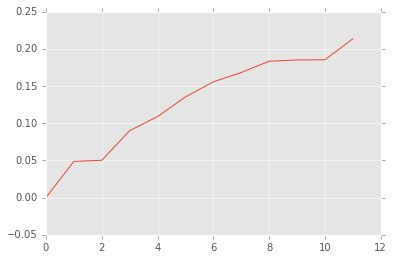

In [13]:
plt.plot(eigval)

In [14]:
e1 = eigvec[:,1]
print((e1>=0).sum(), (e1<0).sum())

1794 79512


(2, 81306)


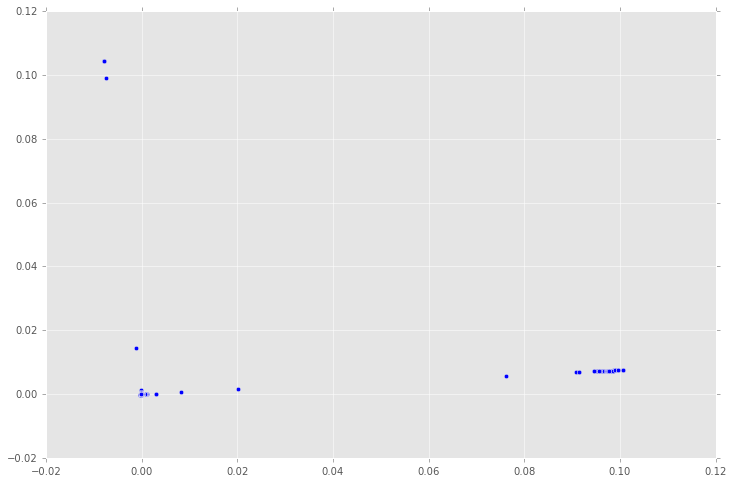

In [15]:
proj = eigvec[:, 1:3].T
print(proj.shape)

pylab.rcParams['figure.figsize'] = (12.0, 8.0)

plt.scatter(proj[0], proj[1])

## kmeans clustering

(81306, 2)
CPU times: user 464 ms, sys: 4 ms, total: 468 ms
Wall time: 119 ms
4
[[-0.00011183 -0.00793462  0.09834324  0.07628022]
 [-0.00012543  0.10446643  0.00735456  0.0056759 ]]


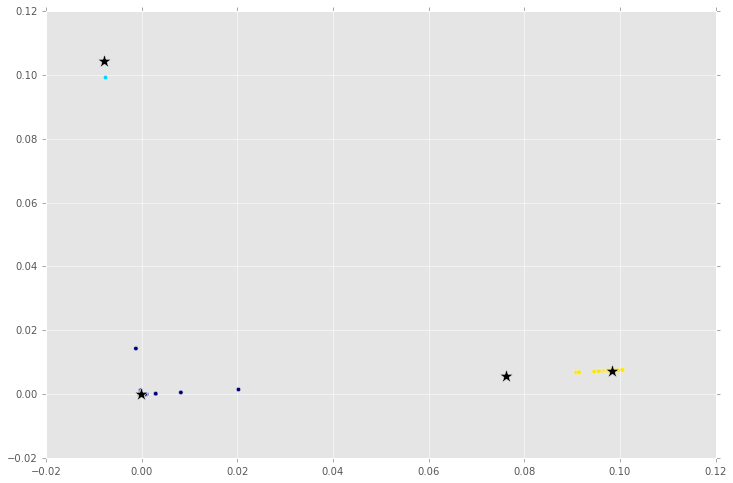

In [16]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

n_clusters = 4

clf = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
#clf = AgglomerativeClustering(n_clusters = n_clusters)
# clf = DBSCAN(eps = 0.005)

print(proj.T.shape)

%time clusters = clf.fit_predict(proj.T)

print(len(np.unique(clusters)))

plt.scatter(proj[0], proj[1], c=clusters)

if "cluster_centers_" in clf.__dict__:
    centers = clf.cluster_centers_.T
    print(centers)
    plt.scatter(centers[0], centers[1], marker='*', s=200, c='black')

In [17]:
print(eigvec.min(axis=0), eigvec.max(axis=0), eigvec.mean(axis=0))
print(1/(eigvec.max(axis=0) - eigvec.min(axis=0)))

[ 0.00339258 -0.00794127 -0.00035489 -0.09664207 -0.0809589  -0.00070121
 -0.07494913 -0.16104829 -0.02921503 -0.09841439 -0.13561624 -0.10767491] [ 0.0035505   0.10057445  0.10452624  0.00057749  0.00088364  0.17268604
  0.00193609  0.00124813  0.08313013  0.10566136  0.00125007  0.0108919 ] [  3.50707606e-03   3.87251885e-06   1.08771587e-06   1.51920051e-06
   1.16164983e-06  -7.05782766e-09  -1.81625339e-07  -1.78497700e-07
  -3.85445702e-07  -5.18699551e-07   3.86922153e-07   5.72537715e-07]
[  6.33207959e+03   9.21525478e+00   9.53460312e+00   1.02859955e+01
   1.22185841e+01   5.76743650e+00   1.30064020e+01   6.16156578e+00
   8.90114021e+00   4.90014124e+00   7.30640030e+00   8.43406296e+00]


In [18]:
eigvec_n = (eigvec-eigvec.min(axis=0)) / (eigvec.max(axis=0) - eigvec.min(axis=0))
print(eigvec_n.shape, eigvec.shape)
print(eigvec_n.mean(axis=0))

(81306, 12) (81306, 12)
[ 0.72502184  0.07321648  0.0033941   0.99407542  0.98921734  0.00404415
  0.97481602  0.9923085   0.26004368  0.48224187  0.99086934  0.90814185]


n_clusters = 2032
(81306, 11)


/home/yannick/bin/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/yannick/bin/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/yannick/bin/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, us

CPU times: user 348 ms, sys: 96 ms, total: 444 ms
Wall time: 3min 26s
2032


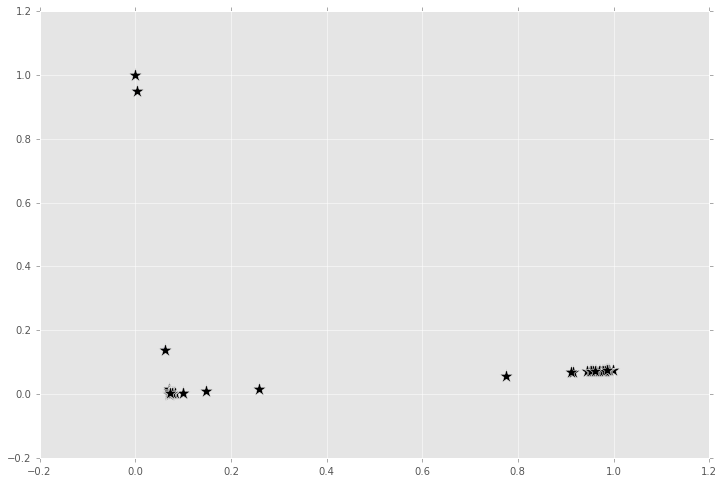

In [19]:
n_clusters = int(v/40)
print("n_clusters = %d" % n_clusters)

clf = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10, n_jobs=4)
#clf = AgglomerativeClustering(n_clusters = n_clusters)
#clf = DBSCAN(eps = 0.0005)

X = eigvec_n[:,1:]

print(X.shape)
%time clusters = clf.fit_predict(X)
print(len(np.unique(clusters)))

plt.scatter(X[:,0], X[:,1], c=clusters)

if "cluster_centers_" in clf.__dict__:
    centers = clf.cluster_centers_.T
    # print(centers)
    plt.scatter(centers[0], centers[1], marker='*', s=200, c='black')

## display clustered graphs

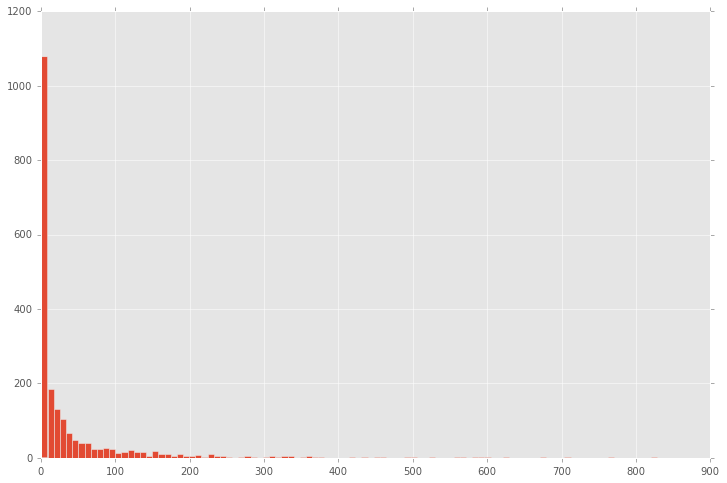

In [20]:
vc = pd.Series(clusters).value_counts()
vc.hist(bins=100)

In [21]:
pd.DataFrame({'cnt': vc}).groupby(["cnt"]).size()

cnt
1      424
2      188
3      120
4       87
5       73
6       45
7       57
8       38
9       46
10      32
11      34
12      26
13      15
14      13
15      20
16      17
17      27
18      20
19      16
20      23
21      13
22      12
23      18
24      16
25      14
26      13
27      11
28      16
29      13
30      12
      ... 
351      1
354      1
355      1
357      1
359      1
360      1
362      1
369      1
374      1
376      1
416      1
433      1
437      1
450      1
460      1
491      1
497      1
505      1
528      1
560      1
567      1
582      1
584      1
591      1
600      1
628      1
676      1
711      1
767      1
828      1
dtype: int64

In [22]:
import networkx as nx

%time g = nx.Graph(list(df.to_records(index=False)))
g

CPU times: user 25 s, sys: 232 ms, total: 25.2 s
Wall time: 25.2 s


Cluster #5 is of size 3
pseudo-degree of cluster is 31


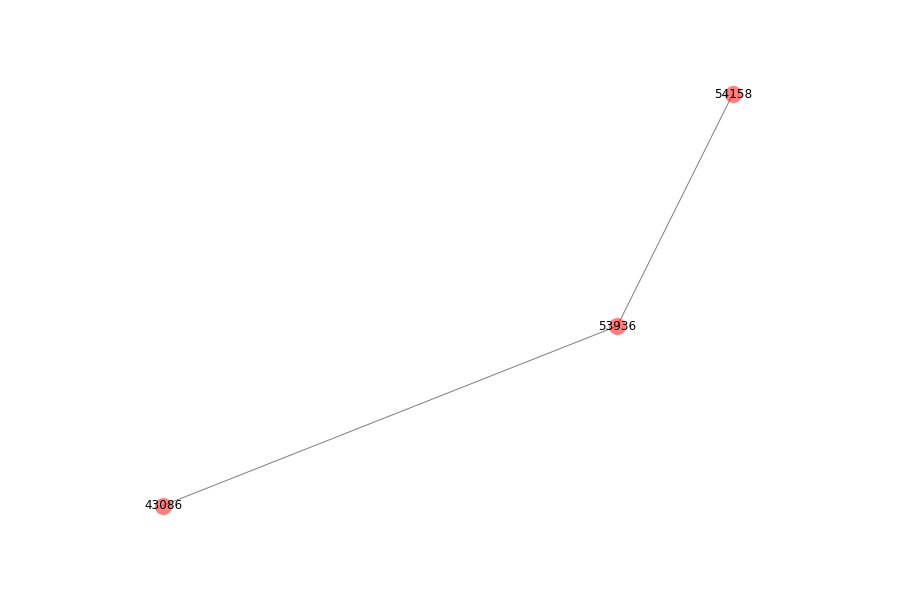

In [23]:
from IPython.html.widgets import interact
import graph_helpers
from imp import reload
reload(graph_helpers)

@interact
def plot(cl = ('5', '6', '7', '8', '10', '20', '30', '27', '215', '42', '1150'), 
         degree=("0", "1", "2"), layout=("spring", "std", "spectral")):
    cl = int(cl)
    print("Cluster #%d is of size %d" % (cl, (clusters == cl).sum()))
    
    print("pseudo-degree of cluster is %d" % graph_helpers.get_deg_sub(facebook2, clusters == cl))
    
    graph_helpers.plot_subgraph_links(facebook2, clusters == cl, int(degree), layout=layout, graph=g)

In [24]:
n = 46401

print((clusters[n]), (clusters == clusters[n]).sum())
print((df["0"] == n).sum())
print((df["1"] == n).sum())
df[(df["1"] == n) | (df["0"] == n)]

1746 81
128
3


,0,1
1679589,46401,11249
1702103,6359,46401
2383045,482,46401
2384153,34575,46401
2408159,46401,38556
2408160,46401,28345
2408161,46401,11852
2408162,46401,44979
2408163,46401,70900
2408164,46401,55162


CPU times: user 1min 32s, sys: 16 ms, total: 1min 32s
Wall time: 1min 32s
count    2032.000000
mean      270.785433
std       697.633015
min         1.000000
25%         9.000000
50%        36.000000
75%       181.000000
max      7161.000000
dtype: float64


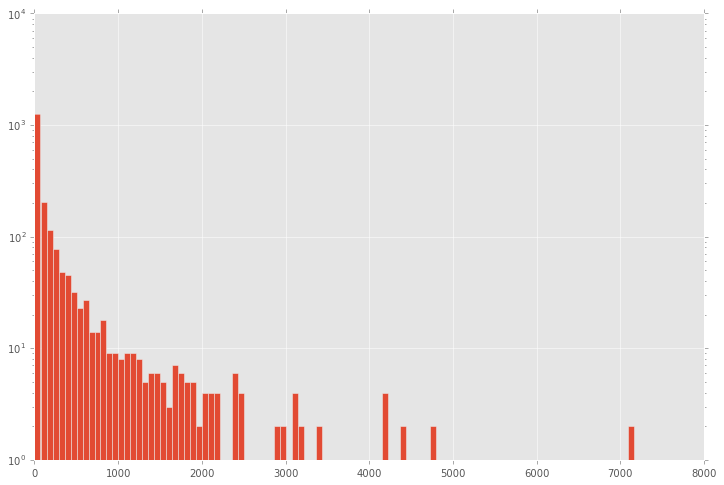

In [29]:
from gmet import group_vertex_degree, group_edge_degree

%time all_degs = [group_vertex_degree(facebook2, clusters == i) for i in range(n_clusters)]

print(pd.Series(all_degs).describe())
_ = plt.hist(all_degs, bins=100)
plt.yscale("log")

In [36]:
from gmet import group_vertex_degree, group_edge_degree

%time cldegs_pd = pd.DataFrame({'sz': [(clusters == cl).sum() for cl in range(n_clusters)], \
                          'vdeg': [group_vertex_degree(facebook2, clusters == i) for i in range(n_clusters)], \
                          'edeg': [group_edge_degree(facebook2, clusters == i) for i in range(n_clusters)]})

cldegs_pd["vratio"] = cldegs_pd.vdeg / cldegs_pd.sz
cldegs_pd["eratio"] = cldegs_pd.edeg / cldegs_pd.sz

cldegs_pd.describe()

CPU times: user 3min 23s, sys: 8 ms, total: 3min 23s
Wall time: 3min 23s


,edeg,sz,vdeg,vratio,eratio
count,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000
mean,774.148622,40.012795,270.785433,10.441588,15.499506
std,2736.143690,81.550834,697.633015,20.888238,23.025275
min,1.000000,1.000000,1.000000,0.011111,0.855670
25%,14.000000,2.000000,9.000000,2.125000,3.666667
50%,61.000000,8.000000,36.000000,5.242647,8.570482
75%,398.750000,37.000000,181.000000,11.017442,19.557456
max,43534.000000,828.000000,7161.000000,439.000000,439.000000


In [37]:
cldegs_pd[cldegs_pd.vratio < 0.5].describe()

,edeg,sz,vdeg,vratio,eratio
count,178.000000,178.000000,178.000000,178.000000,178.000000
mean,43.477528,29.876404,7.707865,0.213133,1.200352
std,87.092859,40.876642,16.041051,0.138701,0.386564
min,3.000000,3.000000,1.000000,0.011111,0.855670
25%,10.000000,10.000000,1.000000,0.090909,1.000000
50%,20.000000,18.500000,2.000000,0.200000,1.056349
75%,35.000000,32.000000,6.000000,0.330619,1.198387
max,702.000000,307.000000,118.000000,0.494382,3.190476


In [38]:
cldegs_pd[cldegs_pd.vratio < 0.5][cldegs_pd.vdeg < 10].describe()

/home/yannick/bin/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,edeg,sz,vdeg,vratio,eratio
count,145.000000,145.000000,145.000000,145.000000,145.000000
mean,19.462069,17.655172,2.455172,0.173192,1.109417
std,13.986611,12.397569,2.078258,0.113518,0.241379
min,3.000000,3.000000,1.000000,0.011111,1.000000
25%,9.000000,9.000000,1.000000,0.076923,1.000000
50%,17.000000,16.000000,2.000000,0.136364,1.000000
75%,26.000000,24.000000,3.000000,0.250000,1.129032
max,90.000000,90.000000,9.000000,0.473684,2.833333


In [39]:
df = cldegs_pd

df[df.eratio < 0.5].describe()

,edeg,sz,vdeg,vratio,eratio
count,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN


0.04463090551181102


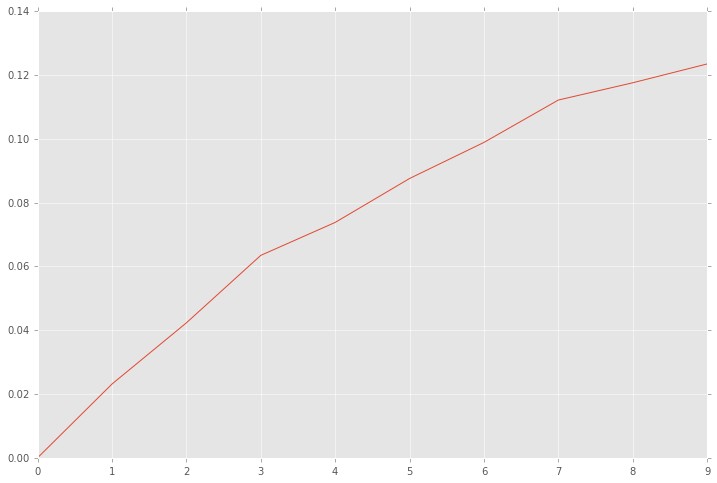

In [40]:
def vratios(df):
    return [len(df[df.vratio < i/10.])/len(df) for i in range(10)]

def perf(df):
    er = vratios(df)
    return sum([i * er[i] / 10. for i in range(10)]) / 10.

er = vratios(cldegs_pd)

print (perf(cldegs_pd))

plt.plot(er)